# Table of Contents

* [1. Load up libraries](#1.-Load-up-libraries)
    * [1.1 Define functions](#1.1-Define-functions)
    * [1.2 Load data from AWS SQL database](#1.2-Load-data-from-AWS-SQL-database) 
        * [1.2.1 A note on SQL database creation on AWS](#1.2.1-A-note-on-SQL-database-creation-on-AWS)
    * [1.3 Build 'bunching' parameter and rearrange data accordingly](#1.3-Build-'bunching'-parameter-and-rearrange-data-accordingly)
        * [1.3.1 Take care of time coarse-graining](#1.3.1-Take-care-of-time-coarse-graining)
        * [1.3.2 Set training data and holdout set](#1.3.2-Set-training-data-and-holdout-set)
        * [1.3.3 Encode data for sklearn random forest](#1.3.3-Encode-data-for-sklearn-random-forest)
    * [1.4 Fit random forest regressor](#1.4-Fit-random-forest-regressor)
* [2. Data story exploration](#2.-Data-story-exploration)
    * [2.1 Route bunching by SF neighborhood- bar plot](#2.1-Route-bunching-by-SF-neighborhood--bar-plot)
    * [2.2 Route bunching by SF neighborhood- heat map](#2.2-Route-bunching-by-SF-neighborhood--heat-map)
    * [2.3 Bunching distribution of all Muni routes](#2.3-Bunching-distribution-of-all-Muni-routes)
    * [2.4 Save bunching distributions by route to disk](#2.4-Save-bunching-distributions-by-route-to-disk)
    * [2.5 Correlations between features](#2.5-Correlations-between-features)
        * [2.5.1 Autocorrelation of predicted arrival times](#2.5.1-Autocorrelation-of-predicted-arrival-times)
* [3. Validation of model](#3.-Validation-of-model)
    * [3.1 Out-of-bag error estimate](#3.1-Out-of-bag-error-estimate)
    * [3.2 Test/train split validation](#3.2-Test/train-split-validation)
    * [3.3 Cross-validation check](#3.3-Cross-validation-check)
    * [3.4 Test/train split plot](#3.4-Test/train-split-plot)
    * [3.5 Cross-validation plot](#3.5-Cross-validation-plot)
    * [3.6 Feature importances](#3.6-Feature-importances)
    * [3.7 Grid search check of parameters](#3.7-Grid-search-check-of-parameters)
* [4. Checks of other models](#4.-Checks-of-other-models)
    * [4.1 kNN regressor](#4.1-kNN-regressor)
    * [4.2 Gradient boosted regressor](#4.2-Gradient-boosted-regressor)
    * [4.3 Linear regression](#4.3-Linear-regression)

# 1. Load up libraries

In [1]:
# all purpose
import datetime, re
from math import radians, cos, sin, asin, sqrt

# for talking to SQL databases
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

# all purpose data analysis and plotting
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# for ML
import patsy
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation, metrics, linear_model, svm
# needed for cross-validation on sets where the test data is not binary/multiclass 
# (i.e. needed for regressors, not classifiers)
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

# for saving output
import pickle

# load up Muni routes
list_of_muni_routes = np.load('/Users/dstone/Dropbox/insight/project/busUnBunchr_site/list_of_muni_routes.npy')

/Library/Python/2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## 1.1 Define functions

Define this function for computing distances in meters from (lat,lon) coordinates

In [2]:
# We will need this function to compute the distance between two (lat,lon) points, in meters
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    meters = 6367 * c * 1000
    return meters

Define this sigmoid function to put all the bunching parameters into an interval [0,1]

In [3]:
def tanh_func(normed_pred_diff):
    # do tanh(1/x) so that x = 0 (on top of each other) gets mapped to 1 (bunched)
    # Multiply by 3 to get steeper fall off, 'bunched(0.5) = 0.57 [chosen ad hoc]
    # offset by 0.01 so np doesn't explode its brain at x=0
    return np.tanh(1/(2*(normed_pred_diff+0.001)))

## 1.2 Load data from AWS SQL database 

(necessary only to load Muni routes and estlabish connection to database)

We need to connect to the PostgresSQL database that I am reading the NextBus Muni data into, which is called 'sf_muni_arrivals' in our case.

**This cell must be run.**

In [5]:
# MUST BE RUNNING 
# ssh -i ~/.ssh/aws_instance_3_instantiated_2016_02_03.pem -L 63333:localhost:5432 ec2-user@ec2-52-72-119-113.compute-1.amazonaws.com
# for this to work (for that specific AWS instance)
remote_dbname = 'sf_muni_arrivals_aws'
remote_username = 'ec2-user'
remote_table = 'nextbus_realtime_with_predictions_and_freqs'

# Open up an engine, that we will use to create the database if it doesn't exist
engine = create_engine('postgres://%s@localhost:63333/%s'%(remote_username,remote_dbname))

if not database_exists(engine.url):
    create_database(engine.url)
    
# If I want to filter the data first:
# connect:
db_con = None
db_con = psycopg2.connect(database = remote_dbname, user = remote_username, port = 63333, host = 'localhost')

Now that the connection to the database has been established, I can actually pull the data down to a local pandas dataframe.

This cell takes a long time to run since it is pulling the database over the net

In [6]:
sql_query = '''SELECT * FROM {table};'''.format(table=remote_table)
df_all = pd.read_sql_query(sql_query, db_con)

### 1.2.1 A note on SQL database creation on AWS

The database that was used above is built in two steps:
    1. Run the call_NextBus_API_with_predictions.py script included in the github repo (on AWS), for as long as you want to collect data. For this project, it was run over a 5 day period in late January. This generates a database that builds pairs of subsequent buses with location, time, speed, and prediction info, but no route frequency info.
    2. Run the Jupyter notebook build_database_with_freqs.ipynb (locally), which will add 'freq' and 'normed_pred_diff' columns necessary for analysis below.

## 1.3 Build 'bunching' parameter and rearrange data accordingly

### 1.3.1 Take care of time coarse-graining
Compose a dictionary, two for each route. For each route, drop all duplicates (taking first and last for first and second part of each dict, respectively). 

In [7]:
bunching_dict={}
for i in list_of_muni_routes:
    my_key1 = 'route_'+str(i)+'_'+str(1)
    my_key2 = 'route_'+str(i)+'_'+str(2)
    if my_key1 not in bunching_dict:
        bunching_dict[my_key1] = 0
    if my_key2 not in bunching_dict:
        bunching_dict[my_key2] = 0 
        
# Declare a total dataframe to take everything in, appending sequentially later
df_total = pd.DataFrame()

Finish defining df_total. We drop duplicates here because we coarse-grain in time to the minute and hence we must be careful about which route pairs we actually train on.

In [8]:
kernel = [0.125,0.25,0.5,1,0.5,0.25,0.125]
terms_to_drop = (len(kernel)-1)/2
for route in list_of_muni_routes:
    for i in range(2):
        key = 'route_'+str(route)+'_'+str(i)
        bunching_dict[key] = df_all[df_all.route_x == str(route)]
        #print bunching_dict[key].head(5)
        if i == 0:
            bunching_dict[key] = bunching_dict[key].drop_duplicates(subset='time', keep='first')
        elif i == 1:
            bunching_dict[key] = bunching_dict[key].drop_duplicates(subset='time', keep='last')
        if not bunching_dict[key].empty:
            bunched_tmp=map(tanh_func,np.convolve(bunching_dict[key]['normed_pred_diff'],kernel)/sum(kernel))
            bunched_tmp=bunched_tmp[terms_to_drop:]
            bunched_tmp=bunched_tmp[:-terms_to_drop]
            bunching_dict[key]['bunched'] = bunched_tmp
            df_total = df_total.append(bunching_dict[key])   

### 1.3.2 Set training data and holdout set
Separate the data into training and testing

In [9]:
# Reserve 0.4 of data for testing
test_data = df_total.sample(frac=0.4, replace=False)
# 0.6 for training
train_data = df_total.loc[~df_total.index.isin(test_data.index)]

### 1.3.3 Encode data for sklearn random forest
Encode the data and then pass it as a matrix. This includes one-hot encoding the routes in the Muni system.

In [10]:
##############################################
# training data
##############################################
# select features to fit on, turn time into hour and minute columns
features = ['lat_x','lon_x','speed_x','time','lat_y','lon_y','speed_y','dist','freq', 'route_x']
xtrain = train_data[features]
xtrain = xtrain.reset_index(drop=True)
xtrain['hour'] = xtrain.apply(lambda row: row['time'].hour, axis=1)
xtrain['minute'] = xtrain.apply(lambda row: row['time'].minute, axis=1)
xtrain.drop('time', inplace=True, axis=1)

# One hot encode the routes
# Need to be a bit careful about encoding. To be safe, we add 
# all routes and then drop them afterward
rows_to_keep = xtrain.shape[0]
for i, route in enumerate(list_of_muni_routes,rows_to_keep+1):
    df_tmp = pd.DataFrame({'route_x': route}, index=[i])
    xtrain = pd.concat([xtrain,df_tmp])
encoding_route = pd.get_dummies(xtrain['route_x'])
xtrain = pd.concat([xtrain,encoding_route], axis=1)
xtrain.drop(['route_x'], inplace=True, axis=1)
xtrain = xtrain.head(rows_to_keep)
xtrain = xtrain.as_matrix()

ytrain = train_data.as_matrix(columns=[train_data.columns[-1]])

##############################################
# testing data
##############################################
# select features to fit on, turn time into hour and minute columns
features = ['lat_x','lon_x','speed_x','time','lat_y','lon_y','speed_y','dist','freq','route_x']
xtest = test_data[features]
xtest = xtest.reset_index(drop=True)
xtest['hour'] = xtest.apply(lambda row: row['time'].hour, axis=1)
xtest['minute'] = xtest.apply(lambda row: row['time'].minute, axis=1)
xtest.drop('time', inplace=True, axis=1)

# One hot encode the routes
# Need to be a bit careful about encoding. To be safe, we add 
# all routes and then drop them afterward
rows_to_keep = xtest.shape[0]
for i, route in enumerate(list_of_muni_routes,rows_to_keep+1):
    df_tmp = pd.DataFrame({'route_x': route}, index=[i])
    xtest = pd.concat([xtest,df_tmp])
encoding_route = pd.get_dummies(xtest['route_x'])
xtest = pd.concat([xtest,encoding_route], axis=1)
xtest.drop(['route_x'], inplace=True, axis=1)
xtest = xtest.head(rows_to_keep)
xtest = xtest.as_matrix()

ytest = test_data.as_matrix(columns=[test_data.columns[-1]])

## 1.4 Fit random forest regressor

In [30]:
# Set up the RFRegressor for later fitting
forest = RandomForestRegressor(n_estimators = 250)

In [35]:
rfr = forest.fit(xtrain,ytrain.ravel())

# 2. Data story exploration

## 2.1 Route bunching by SF neighborhood- bar plot
Look at some of the routes as they are distributed in the bunching parameter:

In [76]:
chinatown_routes = ['8','8AX','8BX','30','45']
train_routes = ['J','K','L','M','N','T']
sunset_routes = ['7','29','48']
mission_routes = ['14','49','12','27','9']
haight_routes = ['33','6','7','21']
portrero_routes = ['10','19','48']
all_routes = [chinatown_routes, sunset_routes, mission_routes, haight_routes, portrero_routes, train_routes]
population_densities = [75055, 14934, 25329, 34253, 9300, 0]

In [12]:
sectors = ['Chinatown','Sunset','Mission','Haight','Portrero Hill','Trains']
percent_highly_bunched = np.zeros(len(all_routes))
for i, sector in enumerate(all_routes):
    #print sector
    highly_bunched = float(df_total[(df_total.route_x.isin(sector)) & (df_total.bunched > 0.90)].shape[0])
    total= float(df_total[df_total.route_x.isin(sector)].shape[0])
    #print highly_bunched/total
    percent_highly_bunched[i] = highly_bunched/total

/Library/Python/2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


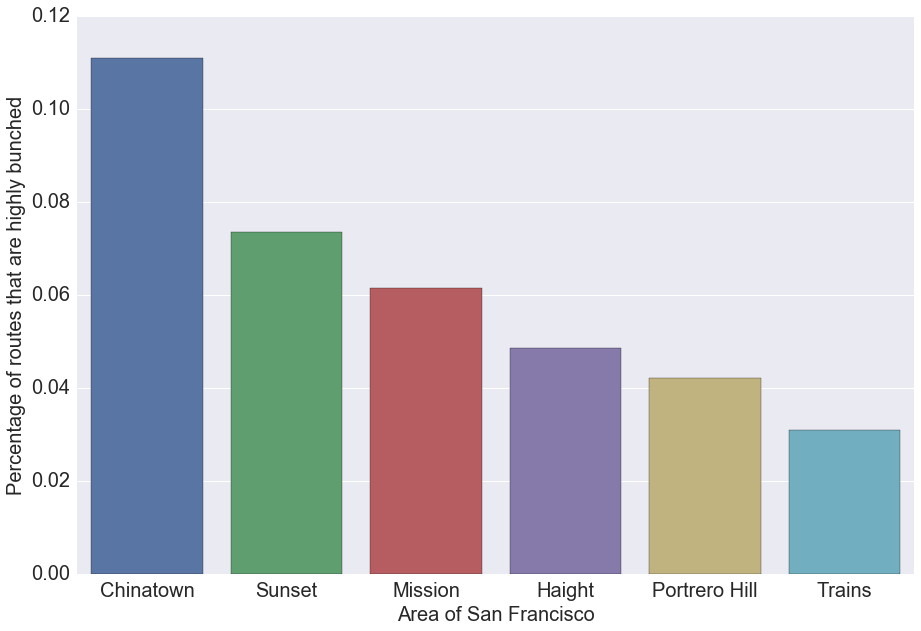

In [13]:
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
#ax.set

ax.tick_params(labelsize=20)
sns.barplot(x=sectors, y=percent_highly_bunched)
ax.set_xlabel('Area of San Francisco', fontsize=20)
ax.set_ylabel('Percentage of routes that are highly bunched',fontsize=20)


## 2.2 Route bunching by SF neighborhood- heat map
We can also display this as a heat map, if I do it right
(this code partially taken from [Andrea Cuttone's blog](https://github.com/andrea-cuttone/blog-code/blob/master/travel-time/boston.ipynb)).



In [ ]:
import geoplotlib
from geoplotlib.utils import BoundingBox
from IPython.display import Image

df_coords = df_total[['lat_x','lon_x','bunched']]
df_coords['lat'] = df_coords.apply(lambda row: round(float(row['lat_x']),4), axis=1)
df_coords['lon'] = df_coords.apply(lambda row: round(float(row['lon_x']),4), axis=1)
df_coords.drop(['lat_x','lon_x'], axis=1, inplace=True)

lat_edges = np.asarray(df_coords.lat.drop_duplicates())[0::3]
lon_edges = np.asarray(df_coords.lon.drop_duplicates())[0::3]

df_grouped = df_coords.groupby(['lat','lon']).mean()

Z = np.empty((len(lat_edges),len(lon_edges)))
Z[:] = np.nan
# construct a table that has averaged weights 
for row, lat in enumerate(lat_edges):
    for col, lon in enumerate(lon_edges):
        try:
            bunching = df_grouped.loc[lat,lon].bunched
            Z[row,col] = bunching
        except:
            Z[row,col] = 0
        #print Z[row,col]

(37.703899999999997, 37.8292)

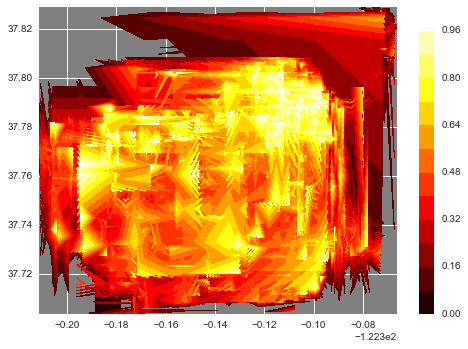

In [22]:
plt.subplot(111, axisbg='gray')
plt.contourf(lon_edges, lat_edges, Z, 12, origin='lower', interpolation='none', cmap='hot', vmax=1)
plt.colorbar()

plt.xlim(lon_edges.min(), lon_edges.max())
plt.ylim(lat_edges.min(), lat_edges.max())

Well, that isn't particularly enlightening.

## 2.3 Bunching distribution of all Muni routes
Here we plot the distribution of all Muni routes in the bunching index

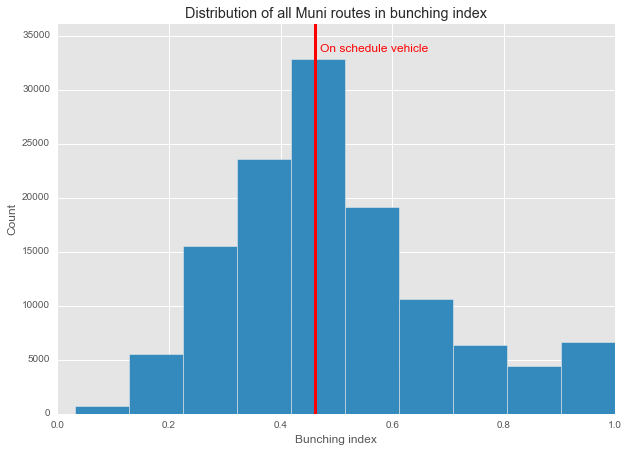

In [36]:
# This gives the 'perfectly on-time' bunch value
on_time_value = tanh_func(1)

#tmp_height, tmp_bins = np.histogram(df_total[df_total.route_x == '30']['bunched'], bins=10)
#tmp_height, tmp_bins = np.histogram(df_total[df_total.route_x.isin(mission_routes)]['bunched'], bins=30)
tmp_height, tmp_bins = np.histogram(df_total['bunched'], bins=10)
plt.style.use('ggplot')
f,a = plt.subplots()
f.set_size_inches(10,7)
width = tmp_bins[1]-tmp_bins[0]
a.bar(tmp_bins[:-1], tmp_height, width = width)
#a.bar(tmp_bins_30[:-1], tmp_height_30, width = width, color='r')
a.set_xlabel('Bunching index')
a.set_ylabel('Count')
#a.set_xlim(0,1)
a.set_ylim(0,max(tmp_height)*1.1)
plt.plot((on_time_value, on_time_value), (0, max(tmp_height)*1.1), 'k-', linewidth=3, color='r')
a.text(0.665, 0.92, 'On schedule vehicle',
#a.text(0.665, 0.92, 
        verticalalignment='bottom', horizontalalignment='right',
        transform=a.transAxes,
        color='red', fontsize=12)
a.set_title('Distribution of all Muni routes in bunching index')

In [17]:
plt.savefig('distribution_in_bunching_parameters.png')

## 2.4 Save bunching distributions by route to disk
Save bunching parameters for each route to disk for later loading

In [116]:
for route in list_of_muni_routes:
    tmp_height, tmp_bins = np.histogram(df_total[df_total.route_x == str(route)]['bunched'], bins=10)
    # This makes the bins and heights equal length, then makes pairs out of them so we have an array
    # [[bin1,count1],[bin2,count2], etc]
    #hist_to_save = np.vstack([tmp_bins[:-1],tmp_height]).ravel([-1]).reshape((-1,2))
    # actually, just pass heights
    hist_to_save = tmp_height
    path_to_file = 'busUnBunchr_site/muni_route_bunching_distributions/'+str(route)+'_distribution'
    np.save(path_to_file, hist_to_save)

In [12]:
# instead, we can also save the raw value of the column (without binning)
for route in list_of_muni_routes:
    bunches_to_save = df_total[df_total.route_x == str(route)]['bunched']
    path_to_file = 'busUnBunchr_site/muni_route_bunching_distributions/'+str(route)+'_raw_counts'
    np.save(path_to_file, bunches_to_save)

## 2.5 Correlations between features

In [71]:
cor_mat = df_total[['time','lat_x','lon_x','route_x','speed_x','time','lat_y','lon_y','speed_y','dist','freq','bunched']].corr()

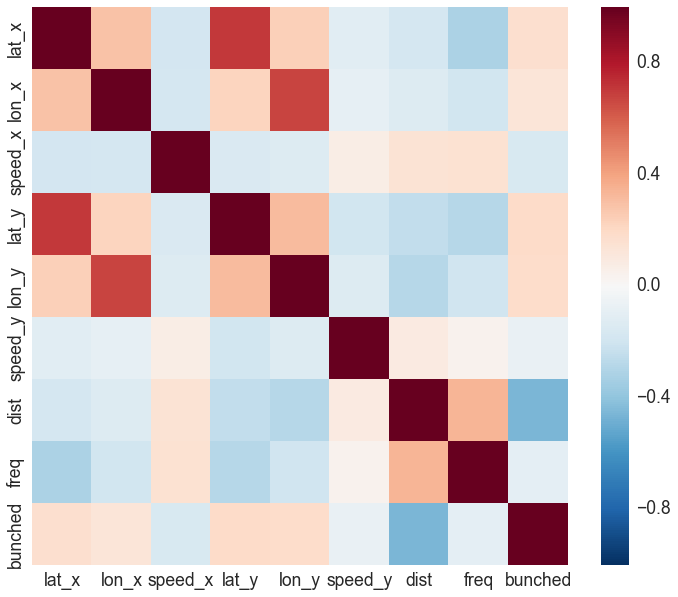

In [75]:
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.75)
sns.heatmap(cor_mat)

### 2.5.1 Autocorrelation of predicted arrival times
The idea being that if the predictions are perfect, we should see a periodic function as predictions go down to zero then bump up again for the next bus and repeat. With poor predictions there should be a bunch of noise in that, which we should be able to see through computing the time autocorrelation

Plotting prediction times of two routes (over the course of many routes):

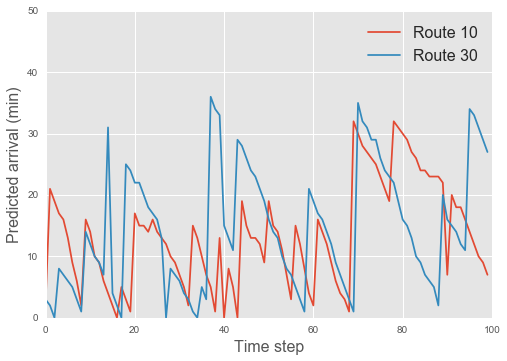

In [63]:
predictions_10 = df_total[df_total.route_x == '10']['pred_x'].astype(int)
predictions_30 = df_total[df_total.route_x == '30']['pred_x'].astype(int)
#indexer = np.random.randint(0,len(predictions_10))
plt.plot(np.asarray(predictions_10[indexer:indexer+100]), label='Route 10')
plt.plot(np.asarray(predictions_30[indexer:indexer+100]), label='Route 30')
plt.ylim([0,50])
plt.legend(fontsize=16)
plt.xlabel('Time step',fontsize=16)
plt.ylabel('Predicted arrival (min)',fontsize=16)
plt.style.use('ggplot')

Now look at autocorrelation of these signals:

In [41]:
tmp_10 = np.asarray(predictions_10).ravel()
# Normalize
tmp_10 = (tmp_10 - np.mean(tmp_10)) / (np.std(tmp_10) * np.sqrt(len(tmp_10)))
tmp_autocorr_10 = np.correlate(tmp_10, tmp_10, mode='same')
# Correlation does a convolution from -\infty to +\infty, but we want 0 to +\infty, so take second half
tmp_autocorr_10 = tmp_autocorr_10[tmp_autocorr_10.size/2:]

tmp_30 = np.asarray(predictions_30).ravel()
# Normalize
tmp_30 = (tmp_30 - np.mean(tmp_30)) / (np.std(tmp_30) * np.sqrt(len(tmp_30)))
tmp_autocorr_30 = np.correlate(tmp_30, tmp_30, mode='same')
# Correlation does a convolution from -\infty to +\infty, but we want 0 to +\infty, so take second half
tmp_autocorr_30 = tmp_autocorr_30[tmp_autocorr_30.size/2:]

For reference: a sine function's autocorrelation

In [144]:
x = np.arange(0, 240, .1);
y = np.sin(x/6)
y = (y - np.mean(y)) / (np.std(y) * np.sqrt(len(y)))

Instead of sine wave, use a more sawtooth that is what ideal bus predictions shoud look like

In [56]:
y = [10, 9.5, 9, 8.5, 8, 7.5, 7, 6.5, 6, 5.5, 5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5, 0]
y= np.repeat(y,4)

y = np.tile(y,800/len(test))
y = (y - np.mean(y)) / (np.std(y) * np.sqrt(len(y)))

In [57]:
y_autocorr = np.correlate(y, y, mode='same')
y_autocorr = y_autocorr[y_autocorr.size/2:]

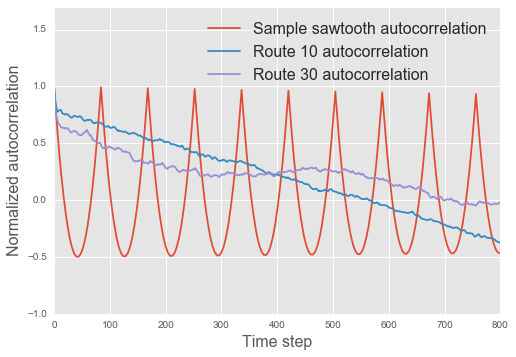

In [62]:
plt.plot(y_autocorr, label='Sample sawtooth autocorrelation')
plt.plot(tmp_autocorr_10, label='Route 10 autocorrelation')
plt.plot(tmp_autocorr_30, label='Route 30 autocorrelation')
plt.xlim([0,800])
plt.ylim([-1,1.7])
plt.xlabel('Time step',fontsize=16)
plt.ylabel('Normalized autocorrelation',fontsize=16)
plt.legend(fontsize=16)

# 3. Validation of the model

## 3.1 Out-of-bag error estimate

Checking the out-of-bag error to consolidate which of the test/train split versus CV accuracies are correct
Train on the **entire** set and look at it's out-of-bag (oob) score to get a baseline for where the error should be

In [12]:
features = ['lat_x','lon_x','speed_x','time','lat_y','lon_y','speed_y','dist','freq', 'route_x']
xtrain_oob = df_total[features]
xtrain_oob = xtrain_oob.reset_index(drop=True)
xtrain_oob['hour'] = xtrain_oob.apply(lambda row: row['time'].hour, axis=1)
xtrain_oob['minute'] = xtrain_oob.apply(lambda row: row['time'].minute, axis=1)
xtrain_oob.drop('time', inplace=True, axis=1)

# Need to be a bit careful about encoding. To be safe, we add 
# all routes and then drop them afterward
rows_to_keep = xtrain_oob.shape[0]
for i, route in enumerate(list_of_muni_routes,rows_to_keep+1):
    df_tmp = pd.DataFrame({'route_x': route}, index=[i])
    xtrain_oob = pd.concat([xtrain_oob,df_tmp])
encoding_route = pd.get_dummies(xtrain_oob['route_x'])
xtrain_oob = pd.concat([xtrain_oob,encoding_route], axis=1)
xtrain_oob.drop(['route_x'], inplace=True, axis=1)
xtrain_oob = xtrain_oob.head(rows_to_keep)
xtrain_oob = xtrain_oob.as_matrix()

ytrain_oob = df_total.as_matrix(columns=[df_total.columns[-1]])

In [20]:
rfr_oob = RandomForestRegressor(n_estimators = 250, oob_score=True)

In [22]:
rfr_oob.fit(xtrain_oob,ytrain_oob.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [23]:
rfr_oob.oob_score_

0.75256855064247974

So our test/train split and CV R^2 values should be in the same ballpark as this value. 

I initially did this because my CV R^2 values were way off, and this was because I was not shuffling the data for the kFolds function. This was a problem because the data was grouped by routes, so when the kFolds did not shuffle the data to do the folding certain routes were completely left out of the training sets.

## 3.2 Test/train split accuracy
Let's look at the accuracy and compute the RMSE and then the R^2

In [38]:
# Compute predictions for each value
preds = rfr.predict(xtest)
rmse = metrics.mean_squared_error(preds, ytest)**0.5
print 'RMSE for model is: {0}'.format(rmse)

RMSE for model is: 0.105559852543


In [39]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ytest[:,0],preds)
print "r-squared for test set:", r_value**2 

r-squared for test set: 0.702996137114


Also look at the root total squared error (i.e. the standard deviation):

In [197]:
np.std(np.asarray(df_total['bunched']))

0.19310419079236329

## 3.3 Cross-validation accuracy
Let's do it with cross validation as well, and get an average (using a bit of Anthony's code here)

First prepare the entire data set for fitting via RF

In [24]:
features = ['lat_x','lon_x','speed_x','time','lat_y','lon_y','speed_y','dist','freq', 'route_x']
xtrain_cv = df_total[features]
xtrain_cv = xtrain_cv.reset_index(drop=True)
xtrain_cv['hour'] = xtrain_cv.apply(lambda row: row['time'].hour, axis=1)
xtrain_cv['minute'] = xtrain_cv.apply(lambda row: row['time'].minute, axis=1)
xtrain_cv.drop('time', inplace=True, axis=1)

# Need to be a bit careful about encoding. To be safe, we add 
# all routes and then drop them afterward
rows_to_keep = xtrain_cv.shape[0]
for i, route in enumerate(list_of_muni_routes,rows_to_keep+1):
    df_tmp = pd.DataFrame({'route_x': route}, index=[i])
    xtrain_cv = pd.concat([xtrain_cv,df_tmp])
encoding_route = pd.get_dummies(xtrain_cv['route_x'])
xtrain_cv = pd.concat([xtrain_cv,encoding_route], axis=1)
xtrain_cv.drop(['route_x'], inplace=True, axis=1)
xtrain_cv = xtrain_cv.head(rows_to_keep)
xtrain_cv = xtrain_cv.as_matrix()

ytrain_cv = df_total.as_matrix(columns=[df_total.columns[-1]])

In [25]:
cv = KFold(n = xtrain_cv.shape[0], n_folds = 3, shuffle=True)
rfr_cv = RandomForestRegressor(n_estimators = 250)
rmse_cv = []
results = {'pred': [],
           'real': []}

for train, test in cv:
    #tmp = xtrain.as_matrix(xtrain.columns)[train]
    rfr_cv.fit(xtrain_cv[train], ytrain_cv[train].ravel())
    pred = rfr_cv.predict(xtrain_cv[test])
    error = metrics.mean_squared_error(pred, ytrain_cv[test].ravel())**0.5
    results['pred'] += list(pred)
    results['real'] += list(ytrain_cv[test].ravel())
    rmse_cv += [error]
print 'RMSE Scores:', rmse_cv
print 'Mean RMSE:', np.mean(rmse_cv)


RMSE Scores: [0.10241341834515442, 0.10117773339396188, 0.099844364526145771]
Mean RMSE: 0.101145172088


In [26]:
slope, intercept, r_value, p_value, std_err = stats.linregress(np.asarray(results['real']).ravel(),np.asarray(results['pred']).ravel())
print "r-squared for CV set:", r_value**2 

r-squared for CV set: 0.727852923823


## 3.4 Test/train split plot
Let's do it with cross validation as well, and get an average (using a bit of Anthony's code here)

We now look at a scatter of predicted bunching values versus actual.

For the test/train split:

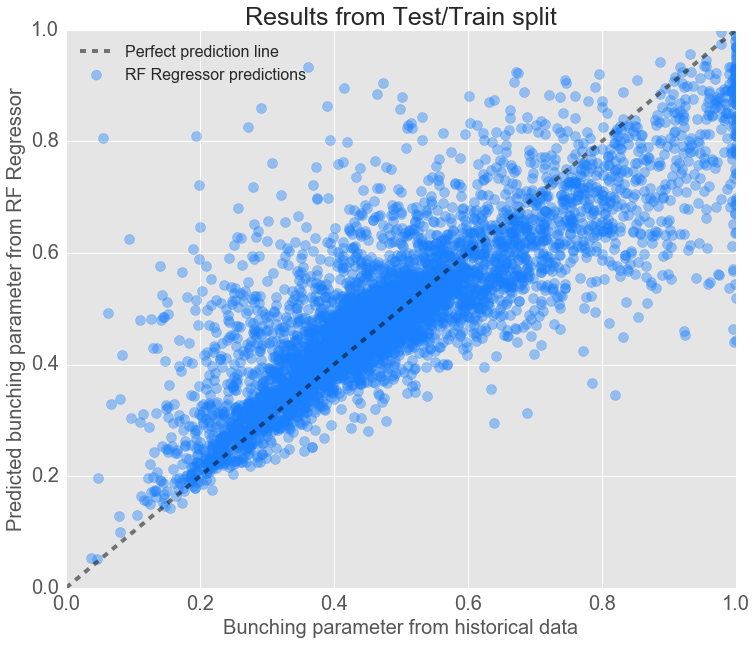

In [41]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (12,10))

# reduce the number of points we are plotting
rand_index = np.random.choice(np.arange(len(ytest)), 5000, replace=False)
y_tmp = ytest[rand_index]
pred_tmp = preds[rand_index]

#(0.6,0.0,0.2)
ax.scatter(y_tmp, pred_tmp, color = (.1,.5,1),
           label = 'RF Regressor predictions',
           s = 100, alpha = 0.4)
ax.plot([0,1],[0,1],'k--', label='Perfect prediction line', color = 'black', lw = 4, alpha = 0.5)
# ax.plot(np.arange(0, 1),np.arange(0, 1), color = 'black',
#            label = 'Perfect Prediction Line',
#            lw = 4, alpha = 0.5, ls = 'dashed')

ax.set_xlabel('Bunching parameter from historical data',fontsize = 20)
ax.set_ylabel('Predicted bunching parameter from RF Regressor', fontsize = 20)
ax.set_title('Results from Test/Train split', fontsize = 25)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend(loc=2, fontsize = 16)
ax.tick_params(labelsize =20)

## 3.5 Cross-validation plot
Let's do it with cross validation as well, and get an average (using a bit of Anthony's code here)

For CV:

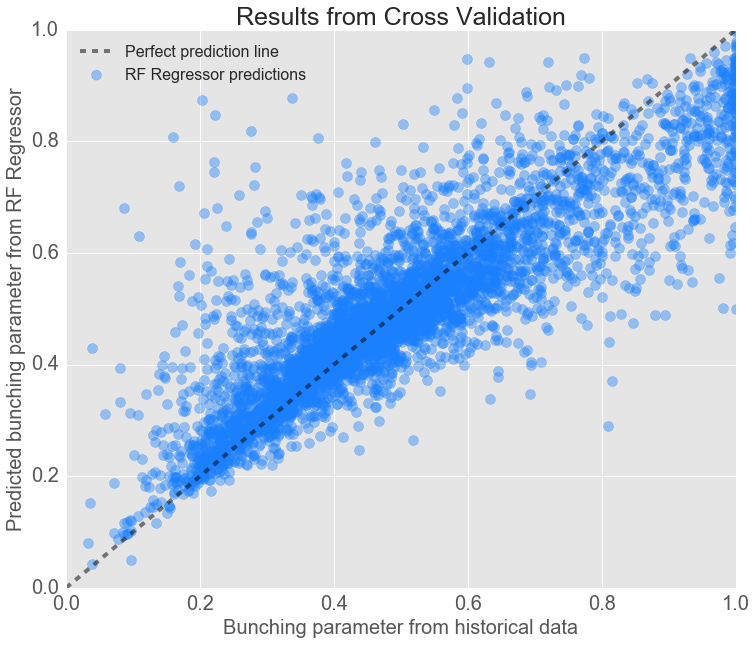

In [28]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (12,10))

# reduce the number of points we are plotting
rand_index = np.random.choice(np.arange(len(ytrain_cv)), 5000, replace=False)
y_tmp = np.asarray(results['real']).ravel()[rand_index]
pred_tmp = np.asarray(results['pred']).ravel()[rand_index]

#(0.6,0.0,0.2)
ax.scatter(y_tmp, pred_tmp, color = (.1,.5,1),
           label = 'RF Regressor predictions',
           s = 100, alpha = 0.4)
ax.plot([0,1],[0,1],'k--', label='Perfect prediction line', color = 'black', lw = 4, alpha = 0.5)
# ax.plot(np.arange(0, 1),np.arange(0, 1), color = 'black',
#            label = 'Perfect Prediction Line',
#            lw = 4, alpha = 0.5, ls = 'dashed')

ax.set_xlabel('Bunching parameter from historical data',fontsize = 20)
ax.set_ylabel('Predicted bunching parameter from RF Regressor', fontsize = 20)
ax.set_title('Results from Cross Validation', fontsize = 25)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend(loc=2, fontsize = 16)
ax.tick_params(labelsize =20)

## 3.6 Feature importances

(0, 7)

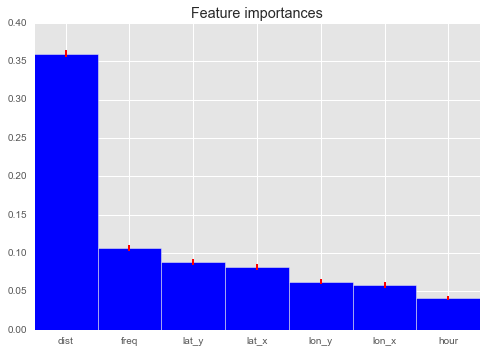

In [70]:
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
# reverses sorted indices so largest are first
indices = np.argsort(importances)[::-1]
#print indices

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
features_to_keep = 7
yerr=std[indices][:features_to_keep]
heights= importances[indices][:features_to_keep]
indices = indices[:features_to_keep]
#plt.figure()
plt.style.use('ggplot')
plt.title("Feature importances")
plt.bar(np.asarray(range(features_to_keep))+0.5, heights, width=1,
       color='b', yerr=yerr, align="center", error_kw=dict(elinewidth=2,ecolor='red'))
plt.xticks(np.asarray(range(features_to_keep))+0.5, tmp_df.columns[indices])
#plt.xlim([-1, xtrain.shape[1]])
plt.xlim([0, features_to_keep])
#plt.show()

## 3.7 Grid search check of parameters
Do a grid search to check the errors of the RF Regressor with more general parameters

In [470]:
from sklearn import grid_search

Grid search on RF

In [482]:
# n_estimators = [10,100,1000]
# max_depth = [1, 4, 8]
# max_features = (also called p) = up to sqrt(number of features)
rfr_params = {'n_estimators': [10,100,1000], 'max_depth': [1,4,8], 'max_features': ('auto','sqrt','log2')}
rfr_grid = RandomForestRegressor()
clf_rfr = grid_search.GridSearchCV(rfr_grid,rfr_params)

In [484]:
clf_rfr.fit(xtrain,ytrain.ravel())

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 1000], 'max_features': ('auto', 'sqrt', 'log2'), 'max_depth': [1, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [496]:
print clf_rfr.best_params_

{'max_features': 'auto', 'n_estimators': 100, 'max_depth': 8}


# 4. Checks with other models

## 4.1 kNN regressor
Attempt with kNN Regression- results not very good

In [152]:
from sklearn import neighbors

Grid search on kNN

In [499]:
# n_estimators = [10,100,1000]
# max_depth = [1, 4, 8]
# max_features = (also called p) = up to sqrt(number of features)
knn_params = {'n_neighbors': np.arange(1,101,10)}
knn_grid = neighbors.KNeighborsRegressor()
clf_knn = grid_search.GridSearchCV(knn_grid,knn_params)

In [500]:
clf_knn.fit(xtrain,ytrain.ravel())

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

Best parameters:

In [502]:
print clf_knn.grid_scores_
print clf_knn.best_params_

[mean: -0.29353, std: 0.07862, params: {'n_neighbors': 1}, mean: 0.26254, std: 0.02834, params: {'n_neighbors': 11}, mean: 0.28852, std: 0.02662, params: {'n_neighbors': 21}, mean: 0.29591, std: 0.02458, params: {'n_neighbors': 31}, mean: 0.30002, std: 0.02384, params: {'n_neighbors': 41}, mean: 0.30235, std: 0.02344, params: {'n_neighbors': 51}, mean: 0.30348, std: 0.02307, params: {'n_neighbors': 61}, mean: 0.30418, std: 0.02273, params: {'n_neighbors': 71}, mean: 0.30453, std: 0.02228, params: {'n_neighbors': 81}, mean: 0.30428, std: 0.02226, params: {'n_neighbors': 91}]
{'n_neighbors': 81}


Now perform fit with best parameters

In [153]:
n_neighbors = 81
knn = neighbors.KNeighborsRegressor(n_neighbors)

In [154]:
knn = knn.fit(xtrain,ytrain)

In [155]:
# Compute predictions for each value
preds = knn.predict(xtest)
rmse = metrics.mean_squared_error(preds, ytest)**0.5
print 'RMSE for model is: {0}'.format(rmse)

RMSE for model is: 0.158587219592


In [158]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ytest[:,0],preds[:,0])
print "r-squared for test set:", r_value**2 

r-squared for test set: 0.330761374607


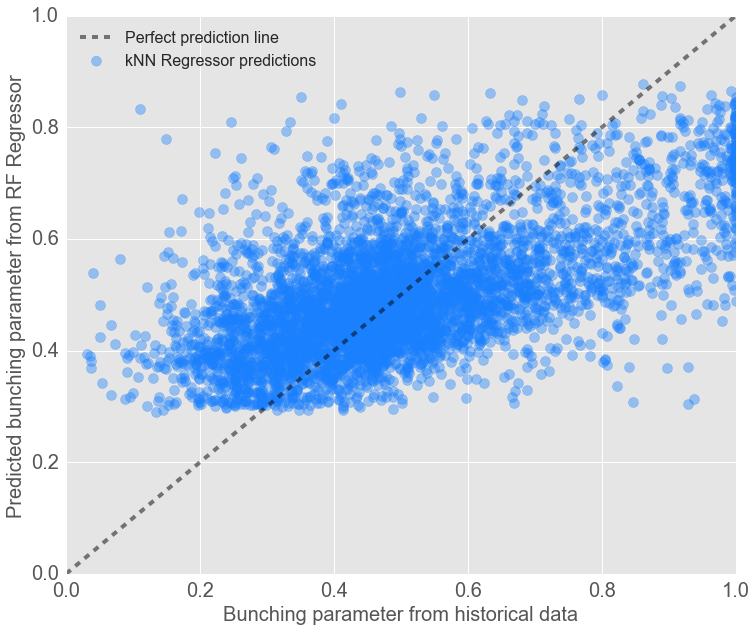

In [160]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (12,10))

# reduce the number of points we are plotting
rand_index = np.random.choice(np.arange(len(ytest)), 5000, replace=False)
y_tmp = ytest[rand_index]
pred_tmp = preds[rand_index]

#(0.6,0.0,0.2)
ax.scatter(y_tmp, pred_tmp, color = (.1,.5,1),
           label = 'kNN Regressor predictions',
           s = 100, alpha = 0.4)
ax.plot([0,1],[0,1],'k--', label='Perfect prediction line', color = 'black', lw = 4, alpha = 0.5)
# ax.plot(np.arange(0, 1),np.arange(0, 1), color = 'black',
#            label = 'Perfect Prediction Line',
#            lw = 4, alpha = 0.5, ls = 'dashed')

ax.set_xlabel('Bunching parameter from historical data',fontsize = 20)
ax.set_ylabel('Predicted bunching parameter from RF Regressor', fontsize = 20)
#ax.set_title('Results from Test Set', fontsize = 25)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend(loc=2, fontsize = 16)
ax.tick_params(labelsize =20)

## 4.2 Gradient boosted regressor
Attempt with GradientBoostedRegressor

In [29]:
# some parameters taken from sklearn documentation, others changed to match RFR values above
# defaults: {'n_estimators': 100, 'min_samples_split': 2, 'learning_rate': 0.1, 'loss': 'ls'}
# alternate for 'loss': 'lad' (least squares ('ls') versus least absolute deviation ('lad'))
params = {'n_estimators': 500, 'min_samples_split': 1,
          'learning_rate': 0.001, 'loss': 'ls', 'verbose': 1, 'presort':False}
gbr = GradientBoostingRegressor(**params)

In [30]:
gbr.fit(xtrain,ytrain.ravel())

      Iter       Train Loss   Remaining Time 
         1           0.0374            5.45m
         2           0.0374            5.59m
         3           0.0374            5.73m
         4           0.0374            5.92m
         5           0.0373            6.15m
         6           0.0373            6.10m
         7           0.0373            6.20m
         8           0.0373            6.20m
         9           0.0372            6.14m
        10           0.0372            6.06m
        20           0.0370            5.66m
        30           0.0367            5.44m
        40           0.0365            5.26m
        50           0.0363            5.11m
        60           0.0360            4.96m
        70           0.0358            4.83m
        80           0.0356            4.72m
        90           0.0354            4.61m
       100           0.0352            4.50m
       200           0.0333            3.38m
       300           0.0317            2.24m
       40

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.001,
             loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=1,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=1,
             warm_start=False)

In [27]:
# Compute predictions for each value
preds = gbr.predict(xtest)
rmse = metrics.mean_squared_error(preds, ytest)**0.5
print 'RMSE for model is: {0}'.format(rmse)

RMSE for model is: 0.186941645399


In [28]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ytest[:,0],preds)
print "r-squared for test set:", r_value**2 

r-squared for test set: 0.3397101634


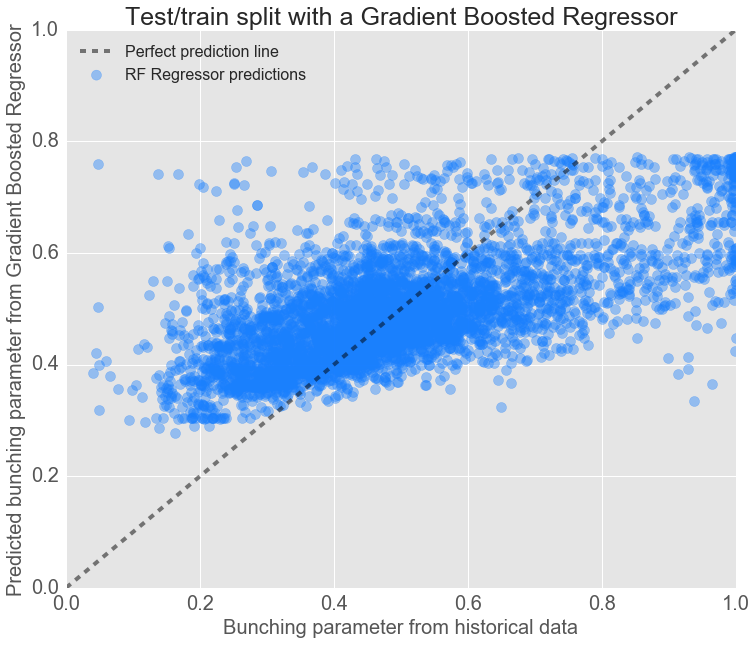

In [15]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (12,10))

# reduce the number of points we are plotting
rand_index = np.random.choice(np.arange(len(ytest)), 5000, replace=False)
y_tmp = ytest[rand_index]
pred_tmp = preds[rand_index]

#(0.6,0.0,0.2)
ax.scatter(y_tmp, pred_tmp, color = (.1,.5,1),
           label = 'RF Regressor predictions',
           s = 100, alpha = 0.4)
ax.plot([0,1],[0,1],'k--', label='Perfect prediction line', color = 'black', lw = 4, alpha = 0.5)
# ax.plot(np.arange(0, 1),np.arange(0, 1), color = 'black',
#            label = 'Perfect Prediction Line',
#            lw = 4, alpha = 0.5, ls = 'dashed')

ax.set_xlabel('Bunching parameter from historical data',fontsize = 20)
ax.set_ylabel('Predicted bunching parameter from Gradient Boosted Regressor', fontsize = 20)
ax.set_title('Test/train split with a Gradient Boosted Regressor', fontsize = 25)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend(loc=2, fontsize = 16)
ax.tick_params(labelsize =20)

## 4.3 Linear regression
Attempt with logit regression

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
# Create the random forest object which will include all the parameters
# for the fit
lr = LinearRegression()
lr = lr.fit(xtrain,ytrain)

In [ ]:
# Compute predictions for each value
preds = lr.predict(xtest)
rmse = metrics.mean_squared_error(preds, ytest)**0.5
print 'RMSE for model is: {0}'.format(rmse)

RMSE for model is: 0.157940326297


In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ytest,preds)
print "r-squared for test set:", r_value**2 

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (12,10))

# reduce the number of points we are plotting
rand_index = np.random.choice(np.arange(len(ytest)), 5000, replace=False)
y_tmp = ytest[rand_index]
pred_tmp = preds[rand_index]

#(0.6,0.0,0.2)
ax.scatter(y_tmp, pred_tmp, color = (.1,.5,1),
           label = 'kNN Regressor predictions',
           s = 100, alpha = 0.4)
ax.plot([0,1],[0,1],'k--', label='Perfect prediction line', color = 'black', lw = 4, alpha = 0.5)
# ax.plot(np.arange(0, 1),np.arange(0, 1), color = 'black',
#            label = 'Perfect Prediction Line',
#            lw = 4, alpha = 0.5, ls = 'dashed')

ax.set_xlabel('Bunching parameter from historical data',fontsize = 20)
ax.set_ylabel('Predicted bunching parameter from RF Regressor', fontsize = 20)
ax.set_title('Test/train split with a Gradient Boosted Regressor', fontsize = 25)
#ax.set_title('Results from Test Set', fontsize = 25)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend(loc=2, fontsize = 16)
ax.tick_params(labelsize =20)